In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import cv2
import time
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, 
    roc_auc_score, confusion_matrix, roc_curve, auc
)
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

warnings.filterwarnings('ignore')

# Configuration
BASE_DIR = "/kaggle/input/hms-harmful-brain-activity-classification/"
df = pd.read_csv(f"{BASE_DIR}train.csv")

copy_df = df.copy()

cols_to_check = ['seizure_vote', 'lpd_vote','gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
copy_df['total_votes'] = copy_df[cols_to_check].sum(axis=1)

# Separate 'other_vote' from the remaining five labels
other_cols = ['other_vote']
remaining_cols = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote']

# Calculate votes for 'other' and sum of remaining five labels
copy_df['other_votes'] = copy_df['other_vote']
copy_df['remaining_votes'] = copy_df[remaining_cols].sum(axis=1)

# Define proto patterns: ~1/2 experts vote "other", ~1/2 vote for one of remaining five
# We'll use a tolerance range (e.g., 0.3 to 0.7) to define "approximately half"
copy_df['other_ratio'] = copy_df['other_votes'] / copy_df['total_votes']
copy_df['remaining_ratio'] = copy_df['remaining_votes'] / copy_df['total_votes']

# Filter for proto patterns where both ratios are approximately 0.5
proto_threshold_min = 0.3
proto_threshold_max = 0.7

proto_mask = (
    (copy_df['other_ratio'] >= proto_threshold_min) & 
    (copy_df['other_ratio'] <= proto_threshold_max) &
    (copy_df['remaining_ratio'] >= proto_threshold_min) & 
    (copy_df['remaining_ratio'] <= proto_threshold_max) &
    (copy_df['other_votes'] > 0) &  # Ensure there are actual 'other' votes
    (copy_df['remaining_votes'] > 0)  # Ensure there are votes for remaining labels
)

# For proto patterns, we need to determine the dominant non-other label
copy_df['max_remaining_column'] = copy_df[remaining_cols].apply(lambda row: row.idxmax(), axis=1)
copy_df['max_remaining_value'] = copy_df[remaining_cols].max(axis=1)

# Create proto dataset
proto_df = copy_df[proto_mask].copy()


label_mapping = {
    'seizure_vote': 'Seizure',
    'lpd_vote': 'LPD', 
    'gpd_vote': 'GPD',
    'lrda_vote': 'LRDA',
    'grda_vote': 'GRDA'
}

proto_df['proto_label'] = proto_df['max_remaining_column'].map(label_mapping)

# Clean up the dataframe
proto_df = proto_df.drop([
    'total_votes', 'other_votes', 'remaining_votes', 
    'other_ratio', 'remaining_ratio', 'max_remaining_column', 
    'max_remaining_value'
], axis=1)

# Split the proto dataset
trainDF, tempDF = train_test_split(proto_df, test_size=0.2, random_state=42)
valDF, testDF = train_test_split(tempDF, test_size=0.5, random_state=42)

brain_activities = ['Seizure', 'GPD', 'LRDA', 'Other', 'GRDA', 'LPD']
activity_mapping = {activity: idx for idx, activity in enumerate(brain_activities)}

In [2]:
trainDF.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,proto_label
36924,76711939,5,36.0,725241474,11,570.0,3095428291,38697,Other,0,0,0,0,1,2,GRDA
48592,2845155914,1,2.0,944227681,4,80.0,473025989,22655,Other,0,2,0,5,0,8,LRDA
69992,3410387626,3,20.0,1397840314,3,20.0,3974123042,44246,Other,0,0,1,0,1,4,GPD
16871,1742789426,3,50.0,331113389,5,390.0,1011758509,4282,Other,0,0,0,1,0,2,LRDA
58184,1417739562,5,38.0,1166977418,7,606.0,3118786449,44246,Other,0,0,1,0,1,4,GPD


In [3]:
class EarlyStopping:
    """Early stopping class to stop training when validation loss stops improving"""
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True, verbose=True):
        """
        Args:
            patience (int): How many epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as an improvement
            restore_best_weights (bool): Whether to restore model weights from best epoch
            verbose (bool): Whether to print early stopping messages
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
            if self.verbose:
                print(f"Validation loss improved to {val_loss:.6f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    if self.verbose:
                        print("Restoring model weights from the best epoch")
                    model.load_state_dict(self.best_weights)
                    
    def save_checkpoint(self, model):
        """Save model weights when validation loss improves"""
        if self.restore_best_weights:
            self.best_weights = model.state_dict().copy()

class HMS_Dataset(Dataset):
    def __init__(self, metaDF, base_dir, activity_mapping):
        self.metaDF = metaDF
        self.base_dir = base_dir
        self.activity_mapping = activity_mapping
        self.resize_transform = transforms.Resize((224, 224))

    def __len__(self):
        return len(self.metaDF)

    def get_HMS_Sprectogram_Image(self, parquet_path, spect_label_offset_seconds):
        temp_df = pd.read_parquet(parquet_path)
        temp_df.drop(['time'], axis=1, inplace=True)

        start = int(spect_label_offset_seconds) // 2
        temp_df = temp_df[start:start+300]
        temp_df = np.log1p(temp_df)
        temp_df /= temp_df.max()
        temp_arr = np.nan_to_num(temp_df.to_numpy(), nan=1e-4)

        temp_arr_uint8 = np.uint8(255 * temp_arr)
        img = cv2.applyColorMap(temp_arr_uint8, cv2.COLORMAP_JET)
        return img

    def __getitem__(self, idx):
        spect_id, label, offset = self.metaDF.iloc[idx][["spectrogram_id", "expert_consensus", "spectrogram_label_offset_seconds"]]
        ppath = f'{self.base_dir}train_spectrograms/{spect_id}.parquet'
        
        img = self.get_HMS_Sprectogram_Image(ppath, offset)
        
        # Normalize to [0, 1] and convert to tensor
        img = img.astype(np.float32) / 255.0
        img_tensor = torch.tensor(img).permute(2, 0, 1)  # (C, H, W)
        X_tensor = self.resize_transform(img_tensor)
        y = self.activity_mapping[label]
        y_tensor = torch.nn.functional.one_hot(torch.tensor(y, dtype=torch.long), num_classes=6).float()

        return X_tensor, y_tensor
        
def load_pretrained_weights(model, weights_path, num_classes=None):
    """
    Load pretrained weights from specific path with proper error handling
    
    Args:
        model: The model to load weights into
        weights_path: Path to the saved weights file
        num_classes: Number of classes in the saved model (if known)
    """
    if os.path.exists(weights_path):
        print(f"Loading pretrained weights from: {weights_path}")
        
        try:
            state_dict = torch.load(weights_path, map_location='cpu')
            
            # Check if classifier dimensions match
            model_dict = model.state_dict()
            
            # Handle classifier size mismatch
            classifier_key = 'classifier.1.weight'  # EfficientNet classifier layer
            if classifier_key in state_dict and classifier_key in model_dict:
                saved_classes = state_dict[classifier_key].shape[0]
                current_classes = model_dict[classifier_key].shape[0]
                
                if saved_classes != current_classes:
                    print(f"Classifier size mismatch detected:")
                    print(f"  Saved model: {saved_classes} classes")
                    print(f"  Current model: {current_classes} classes")
                    
                    # Adjust model classifier to match saved weights
                    feature_dim = state_dict[classifier_key].shape[1]
                    model.classifier[1] = torch.nn.Linear(feature_dim, saved_classes)
                    print(f"  Adjusted current model to {saved_classes} classes")
            
            # Load the weights
            model.load_state_dict(state_dict, strict=False)
            print("Pretrained weights loaded successfully!")
            
        except RuntimeError as e:
            if "size mismatch" in str(e):
                print(f"Size mismatch error: {e}")
                print("Attempting to load compatible layers only...")
                
                # Load only compatible layers
                model_dict = model.state_dict()
                filtered_dict = {}
                
                for k, v in state_dict.items():
                    if k in model_dict and v.size() == model_dict[k].size():
                        filtered_dict[k] = v
                    else:
                        print(f"  Skipping layer {k}: size mismatch")
                
                model_dict.update(filtered_dict)
                model.load_state_dict(model_dict)
                print(f"Loaded {len(filtered_dict)} compatible layers")
            else:
                raise e
                
    else:
        print(f"Warning: Pretrained weights not found at {weights_path}")
        print("Using default ImageNet weights instead...")
        # Fallback to default pretrained weights
        model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
        
    return model


In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                epochs=20, device="cuda", checkpoint_path="best_efficientnet_model.pth", 
                log_file_path="HMS_Training_log_v1.csv", early_stopping_patience=10, 
                early_stopping_min_delta=0.001):
    """
    Train model with early stopping
    
    Args:
        early_stopping_patience (int): Number of epochs to wait for improvement
        early_stopping_min_delta (float): Minimum change to qualify as improvement
    """
    
    if os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path))
        print(f"Loaded existing checkpoint from {checkpoint_path}")
    
    best_val_accuracy = 0.0
    
    # Initialize early stopping
    early_stopping = EarlyStopping(
        patience=early_stopping_patience, 
        min_delta=early_stopping_min_delta,
        restore_best_weights=True,
        verbose=True
    )

    with open(log_file_path, "w") as f:
        f.write("epoch#,train_loss,train_accuracy,val_loss,val_accuracy,time_taken\n")
    
    print(f"Training with early stopping (patience={early_stopping_patience}, min_delta={early_stopping_min_delta})")
    
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, torch.argmax(y, dim=1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(torch.argmax(y, dim=1)).sum().item()

        train_accuracy = 100. * correct / total
        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, torch.argmax(y, dim=1))
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += y.size(0)
                correct += predicted.eq(torch.argmax(y, dim=1)).sum().item()

        val_accuracy = 100. * correct / total
        avg_val_loss = val_loss / len(val_loader)
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Save best model based on accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best model saved with Validation Accuracy: {val_accuracy:.2f}%")

        # Early stopping check
        early_stopping(avg_val_loss, model)
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")
        
        # Log training progress
        with open(log_file_path, "a") as f:
            f.write(f"{epoch+1},{avg_train_loss:.4f},{train_accuracy:.2f},{avg_val_loss:.4f},{val_accuracy:.2f},{epoch_time:.2f}\n")

        # Check if early stopping triggered
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered after {epoch+1} epochs!")
            print(f"Best validation loss was: {early_stopping.best_loss:.6f}")
            break
    
    if not early_stopping.early_stop:
        print(f"\nTraining completed all {epochs} epochs.")
    
    print(f"Training complete. Best Validation Accuracy: {best_val_accuracy:.2f}%")
    return model

def test_model(model, test_loader, checkpoint_path="best_efficientnet_model.pth", device="cuda"):
    # Load Model
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    model.eval()

    mname = checkpoint_path.split(".")[0]
    # Lists to store predictions and true labels
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(torch.argmax(y, dim=1).cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Compute Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    kappa = cohen_kappa_score(all_labels, all_preds)

    # Compute Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f"{mname}_confusion_matrix.png")
    plt.close()

    # Compute AUC & ROC
    num_classes = all_probs.shape[1]
    auc_scores = []
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    macro_auc = np.mean(auc_scores)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.savefig(f"{mname}_roc_curve.png")
    plt.close()

    # Print Metrics
    print(f"Test Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1-Score: {f1:.2%}")
    print(f"Kappa Score: {kappa:.2f}")
    print(f"AUC: {macro_auc:.2f}")

    return accuracy, precision, recall, f1, kappa, macro_auc

In [5]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score,
    roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve,
    average_precision_score, balanced_accuracy_score, matthews_corrcoef,
    log_loss, brier_score_loss, classification_report
)
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class ComprehensiveModelEvaluator:
    def __init__(self, model, test_loader, val_loader, device, num_classes=6, 
                 class_names=['Seizure', 'GPD', 'LRDA', 'Other', 'GRDA', 'LPD']):
        self.model = model
        self.test_loader = test_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.class_names = class_names
        self.results = {}
        
    def extract_features_and_predictions(self, data_loader, extract_features=False):
        """Extract predictions, probabilities, and optionally features"""
        self.model.eval()
        all_preds, all_labels, all_probs = [], [], []
        all_features = [] if extract_features else None
        inference_times = []
        
        with torch.no_grad():
            for X, y in data_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                # Measure inference time
                start_time = time.time()
                
                if extract_features:
                    # Extract features from the layer before classifier
                    features = self.model.features(X)
                    features = self.model.avgpool(features)
                    features = torch.flatten(features, 1)
                    all_features.extend(features.cpu().numpy())
                    outputs = self.model.classifier(features)
                else:
                    outputs = self.model(X)
                
                inference_time = (time.time() - start_time) * 1000  # Convert to ms
                inference_times.append(inference_time)
                
                probs = F.softmax(outputs, dim=1)
                _, predicted = outputs.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(torch.argmax(y, dim=1).cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        return (np.array(all_preds), np.array(all_labels), np.array(all_probs), 
                np.array(all_features) if extract_features else None, inference_times)
    
    def calculate_basic_metrics(self, y_true, y_pred, y_prob):
        """Calculate basic classification metrics"""
        metrics = {}
        
        # Basic metrics
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro')
        metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro')
        metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro')
        metrics['precision_micro'] = precision_score(y_true, y_pred, average='micro')
        metrics['recall_micro'] = recall_score(y_true, y_pred, average='micro')
        metrics['f1_micro'] = f1_score(y_true, y_pred, average='micro')
        metrics['precision_weighted'] = precision_score(y_true, y_pred, average='weighted')
        metrics['recall_weighted'] = recall_score(y_true, y_pred, average='weighted')
        metrics['f1_weighted'] = f1_score(y_true, y_pred, average='weighted')
        
        # Additional metrics
        metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
        metrics['cohen_kappa'] = cohen_kappa_score(y_true, y_pred)
        metrics['matthews_corr'] = matthews_corrcoef(y_true, y_pred)
        
        # Log loss and Brier score
        y_true_onehot = label_binarize(y_true, classes=range(self.num_classes))
        if self.num_classes == 2:
            y_true_onehot = np.hstack([1-y_true_onehot, y_true_onehot])
        
        metrics['log_loss'] = log_loss(y_true_onehot, y_prob)
        metrics['brier_score'] = brier_score_loss(y_true_onehot.ravel(), y_prob.ravel())
        
        return metrics
    
    def calculate_auc_metrics(self, y_true, y_prob):
        """Calculate AUC-related metrics"""
        metrics = {}
        
        # Multi-class AUC-ROC
        try:
            metrics['auc_roc_macro'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
            metrics['auc_roc_weighted'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
        except:
            metrics['auc_roc_macro'] = 0.0
            metrics['auc_roc_weighted'] = 0.0
        
        # Class-wise AUC-ROC
        class_auc_roc = []
        for i in range(self.num_classes):
            try:
                auc_score = roc_auc_score((y_true == i).astype(int), y_prob[:, i])
                class_auc_roc.append(auc_score)
            except:
                class_auc_roc.append(0.0)
        metrics['class_auc_roc'] = class_auc_roc
        
        # Precision-Recall AUC
        class_auc_pr = []
        for i in range(self.num_classes):
            try:
                precision, recall, _ = precision_recall_curve((y_true == i).astype(int), y_prob[:, i])
                auc_pr = auc(recall, precision)
                class_auc_pr.append(auc_pr)
            except:
                class_auc_pr.append(0.0)
        
        metrics['auc_pr_macro'] = np.mean(class_auc_pr)
        metrics['class_auc_pr'] = class_auc_pr
        
        # Average Precision Score
        metrics['avg_precision_macro'] = average_precision_score(
            label_binarize(y_true, classes=range(self.num_classes)), y_prob, average='macro'
        )
        
        return metrics
    
    def calculate_classwise_metrics(self, y_true, y_pred, y_prob):
        """Calculate class-wise metrics"""
        precision_class = precision_score(y_true, y_pred, average=None)
        recall_class = recall_score(y_true, y_pred, average=None)
        f1_class = f1_score(y_true, y_pred, average=None)
        
        # Calculate specificity for each class
        cm = confusion_matrix(y_true, y_pred)
        specificity_class = []
        
        for i in range(self.num_classes):
            tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
            fp = np.sum(cm[:, i]) - cm[i, i]
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            specificity_class.append(specificity)
        
        return {
            'precision_class': precision_class,
            'recall_class': recall_class,
            'f1_class': f1_class,
            'specificity_class': np.array(specificity_class)
        }
    
    def calculate_calibration_metrics(self, y_true, y_prob):
        """Calculate calibration metrics"""
        # Expected Calibration Error (ECE)
        def expected_calibration_error(y_true, y_prob, n_bins=10):
            bin_boundaries = np.linspace(0, 1, n_bins + 1)
            bin_lowers = bin_boundaries[:-1]
            bin_uppers = bin_boundaries[1:]
            
            ece = 0
            for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
                in_bin = (y_prob.max(axis=1) > bin_lower) & (y_prob.max(axis=1) <= bin_upper)
                prop_in_bin = in_bin.mean()
                
                if prop_in_bin > 0:
                    accuracy_in_bin = (y_true[in_bin] == y_prob[in_bin].argmax(axis=1)).mean()
                    avg_confidence_in_bin = y_prob[in_bin].max(axis=1).mean()
                    ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            
            return ece
        
        ece = expected_calibration_error(y_true, y_prob)
        
        # Calibration slope and intercept (for binary case, approximate for multiclass)
        confidences = y_prob.max(axis=1)
        predictions = y_prob.argmax(axis=1)
        accuracies = (y_true == predictions).astype(float)
        
        # Simple linear regression for calibration
        A = np.vstack([confidences, np.ones(len(confidences))]).T
        slope, intercept = np.linalg.lstsq(A, accuracies, rcond=None)[0]
        
        return {
            'ece': ece,
            'calibration_slope': slope,
            'calibration_intercept': intercept
        }
    
    def calculate_topk_accuracy(self, y_true, y_prob, k_values=[1, 3, 5]):
        """Calculate top-k accuracy"""
        topk_accuracies = {}
        
        for k in k_values:
            if k <= self.num_classes:
                top_k_preds = np.argsort(y_prob, axis=1)[:, -k:]
                correct = np.array([y_true[i] in top_k_preds[i] for i in range(len(y_true))])
                topk_accuracies[f'top_{k}_accuracy'] = correct.mean()
        
        return topk_accuracies
    
    def calculate_model_complexity(self):
        """Calculate model complexity metrics"""
        # Parameter count
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        # Model size (approximate)
        param_size = sum(p.numel() * p.element_size() for p in self.model.parameters())
        buffer_size = sum(b.numel() * b.element_size() for b in self.model.buffers())
        model_size_mb = (param_size + buffer_size) / (1024 * 1024)
        
        return {
            'total_params': total_params,
            'trainable_params': trainable_params,
            'total_params_m': total_params / 1e6,
            'model_size_mb': model_size_mb
        }
    
    def evaluate_model(self, checkpoint_path=None):
        """Comprehensive model evaluation"""
        print("Starting comprehensive model evaluation...")
        start_time = datetime.now()
        
        # Load model if checkpoint provided
        if checkpoint_path and os.path.exists(checkpoint_path):
            self.model.load_state_dict(torch.load(checkpoint_path, map_location=self.device))
            print(f"Loaded model from {checkpoint_path}")
        
        self.model.to(self.device)
        
        # Extract predictions and features
        print("Extracting predictions and features...")
        y_pred, y_true, y_prob, features, inference_times = self.extract_features_and_predictions(
            self.test_loader, extract_features=True
        )
        
        # Calculate all metrics
        print("Calculating metrics...")
        
        # Basic metrics
        basic_metrics = self.calculate_basic_metrics(y_true, y_pred, y_prob)
        self.results.update(basic_metrics)
        
        # AUC metrics
        auc_metrics = self.calculate_auc_metrics(y_true, y_prob)
        self.results.update(auc_metrics)
        
        # Class-wise metrics
        classwise_metrics = self.calculate_classwise_metrics(y_true, y_pred, y_prob)
        self.results.update(classwise_metrics)
        
        # Calibration metrics
        calibration_metrics = self.calculate_calibration_metrics(y_true, y_prob)
        self.results.update(calibration_metrics)
        
        # Top-k accuracy
        topk_metrics = self.calculate_topk_accuracy(y_true, y_prob)
        self.results.update(topk_metrics)
        
        # Model complexity
        complexity_metrics = self.calculate_model_complexity()
        self.results.update(complexity_metrics)
        
        # Performance metrics
        avg_inference_time = np.mean(inference_times)
        throughput = len(y_true) / (sum(inference_times) / 1000)  # samples per second
        
        self.results.update({
            'avg_inference_time_ms': avg_inference_time,
            'throughput_samples_per_sec': throughput,
            'total_test_samples': len(y_true)
        })
        
        # Store data for visualizations
        self.y_true = y_true
        self.y_pred = y_pred
        self.y_prob = y_prob
        self.features = features
        
        end_time = datetime.now()
        evaluation_time = (end_time - start_time).total_seconds() / 3600  # in hours
        
        self.results.update({
            'evaluation_start_time': start_time.strftime('%Y-%m-%d %H:%M:%S'),
            'evaluation_end_time': end_time.strftime('%Y-%m-%d %H:%M:%S'),
            'evaluation_time_hours': evaluation_time
        })
        
        print("Model evaluation completed!")

        # Add KL divergence metrics
        kl_metrics = self.calculate_kl_divergence_metrics(y_true, y_prob)
        self.results.update(kl_metrics)

        return self.results
    
    def print_results(self):
        """Print formatted results"""
        print("\n" + "="*80)
        print("COMPREHENSIVE MODEL EVALUATION RESULTS")
        print("="*80)
        
        print(f"\n📊 BASIC METRICS:")
        print(f"Accuracy: {self.results['accuracy']:.4f}")
        print(f"Precision (Macro): {self.results['precision_macro']:.4f}")
        print(f"Recall (Macro): {self.results['recall_macro']:.4f}")
        print(f"F1 Score (Macro): {self.results['f1_macro']:.4f}")
        print(f"Balanced Accuracy: {self.results['balanced_accuracy']:.4f}")
        print(f"Cohen's Kappa: {self.results['cohen_kappa']:.4f}")
        print(f"Matthews Correlation: {self.results['matthews_corr']:.4f}")
        
        print(f"\n🎯 AUC METRICS:")
        print(f"AUC-ROC (Macro): {self.results['auc_roc_macro']:.4f}")
        print(f"AUC-PRC (Macro): {self.results['auc_pr_macro']:.4f}")
        print(f"Average Precision Score: {self.results['avg_precision_macro']:.4f}")
        
        print(f"\n📈 CALIBRATION METRICS:")
        print(f"Expected Calibration Error: {self.results['ece']:.4f}")
        print(f"Brier Score: {self.results['brier_score']:.4f}")
        print(f"Log Loss: {self.results['log_loss']:.4f}")
        
        print(f"\n🔧 MODEL COMPLEXITY:")
        print(f"Total Parameters: {self.results['total_params_m']:.2f}M")
        print(f"Model Size: {self.results['model_size_mb']:.2f} MB")
        
        print(f"\n⚡ PERFORMANCE:")
        print(f"Avg Inference Time: {self.results['avg_inference_time_ms']:.2f} ms/sample")
        print(f"Throughput: {self.results['throughput_samples_per_sec']:.2f} samples/sec")
        
        print(f"\n🏷️ CLASS-WISE METRICS:")
        for i, class_name in enumerate(self.class_names):
            print(f"{class_name}:")
            print(f"  Precision: {self.results['precision_class'][i]:.4f}")
            print(f"  Recall: {self.results['recall_class'][i]:.4f}")
            print(f"  F1-Score: {self.results['f1_class'][i]:.4f}")
            print(f"  Specificity: {self.results['specificity_class'][i]:.4f}")
            print(f"  AUC-ROC: {self.results['class_auc_roc'][i]:.4f}")
            print(f"  AUC-PRC: {self.results['class_auc_pr'][i]:.4f}")
        
        if 'top_3_accuracy' in self.results:
            print(f"\n🎯 TOP-K ACCURACY:")
            for key in self.results:
                if key.startswith('top_') and key.endswith('_accuracy'):
                    print(f"{key.replace('_', '-').title()}: {self.results[key]:.4f}")

        print(f"\n📊 KL DIVERGENCE METRICS:")
        print(f"KL Divergence (Mean): {self.results['kl_divergence_mean']:.4f}")
        print(f"KL Divergence (Std): {self.results['kl_divergence_std']:.4f}")
        print(f"KL Divergence (Median): {self.results['kl_divergence_median']:.4f}")
        print(f"Reverse KL Divergence (Mean): {self.results['reverse_kl_divergence_mean']:.4f}")
        print(f"Jensen-Shannon Divergence (Mean): {self.results['js_divergence_mean']:.4f}")
        print(f"Class Distribution KL: {self.results['class_distribution_kl']:.4f}")
        print(f"High Confidence KL (Mean): {self.results['high_confidence_kl_mean']:.4f}")
        print(f"Low Confidence KL (Mean): {self.results['low_confidence_kl_mean']:.4f}")
    
    def create_visualizations(self, save_prefix="model_evaluation"):
        """Create comprehensive visualizations"""
        plt.style.use('default')
        
        # 1. Confusion Matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(self.y_true, self.y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.savefig(f'{save_prefix}_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 2. ROC Curves
        plt.figure(figsize=(12, 8))
        for i in range(self.num_classes):
            fpr, tpr, _ = roc_curve((self.y_true == i).astype(int), self.y_prob[:, i])
            auc_score = self.results['class_auc_roc'][i]
            plt.plot(fpr, tpr, label=f'{self.class_names[i]} (AUC = {auc_score:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - All Classes')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{save_prefix}_roc_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 3. Precision-Recall Curves
        plt.figure(figsize=(12, 8))
        for i in range(self.num_classes):
            precision, recall, _ = precision_recall_curve((self.y_true == i).astype(int), self.y_prob[:, i])
            auc_pr = self.results['class_auc_pr'][i]
            plt.plot(recall, precision, label=f'{self.class_names[i]} (AUC = {auc_pr:.3f})')
        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves - All Classes')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{save_prefix}_pr_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 4. t-SNE Visualization
        if self.features is not None:
            print("Creating t-SNE visualization...")
            tsne = TSNE(n_components=2, random_state=42, perplexity=30)
            features_2d = tsne.fit_transform(self.features[:1000])  # Limit for performance
            
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                                c=self.y_true[:1000], cmap='tab10', alpha=0.7)
            plt.colorbar(scatter, ticks=range(self.num_classes), 
                        label='Class')
            plt.title('t-SNE Visualization of Feature Space')
            plt.xlabel('t-SNE Component 1')
            plt.ylabel('t-SNE Component 2')
            
            # Add legend
            for i, class_name in enumerate(self.class_names):
                plt.scatter([], [], c=plt.cm.tab10(i), label=class_name)
            plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.savefig(f'{save_prefix}_tsne.png', dpi=300, bbox_inches='tight')
            plt.show()
        
        # 5. Reliability Diagram (Calibration Plot)
        plt.figure(figsize=(10, 8))
        n_bins = 10
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        confidences = self.y_prob.max(axis=1)
        predictions = self.y_prob.argmax(axis=1)
        accuracies = (self.y_true == predictions).astype(float)
        
        avg_confs, avg_accs = [], []
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
            prop_in_bin = in_bin.mean()
            
            if prop_in_bin > 0:
                avg_conf = confidences[in_bin].mean()
                avg_acc = accuracies[in_bin].mean()
                avg_confs.append(avg_conf)
                avg_accs.append(avg_acc)
        
        plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
        plt.plot(avg_confs, avg_accs, 'bo-', label='Model Calibration')
        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title('Reliability Diagram (Calibration Plot)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{save_prefix}_calibration.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 6. Class-wise Performance Metrics
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        metrics_to_plot = ['precision_class', 'recall_class', 'f1_class', 'specificity_class']
        titles = ['Precision', 'Recall', 'F1-Score', 'Specificity']
        
        for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
            ax = axes[idx // 2, idx % 2]
            values = self.results[metric]
            bars = ax.bar(self.class_names, values, color=plt.cm.viridis(np.linspace(0, 1, len(values))))
            ax.set_title(f'Class-wise {title}')
            ax.set_ylabel(title)
            ax.set_ylim(0, 1)
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{value:.3f}', ha='center', va='bottom')
            
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig(f'{save_prefix}_classwise_metrics.png', dpi=300, bbox_inches='tight')
        plt.show()
        # Create KL divergence visualizations
        self.create_kl_divergence_visualizations(save_prefix)

    def create_kl_divergence_visualizations(self, save_prefix="model_evaluation"):
        """Create visualizations for KL divergence analysis"""
        
        # 1. KL Divergence Distribution
        plt.figure(figsize=(12, 8))
        
        # Calculate KL divergences for visualization
        y_true_onehot = np.zeros((len(self.y_true), self.num_classes))
        y_true_onehot[np.arange(len(self.y_true)), self.y_true] = 1
        
        kl_divergences = []
        for i in range(len(self.y_true)):
            p = y_true_onehot[i] + 1e-10
            q = self.y_prob[i] + 1e-10
            kl_div = entropy(p, q)
            kl_divergences.append(kl_div)
        
        plt.subplot(2, 2, 1)
        plt.hist(kl_divergences, bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('KL Divergence')
        plt.ylabel('Frequency')
        plt.title('Distribution of KL Divergences')
        plt.axvline(np.mean(kl_divergences), color='red', linestyle='--', 
                    label=f'Mean: {np.mean(kl_divergences):.3f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. KL Divergence vs Confidence
        plt.subplot(2, 2, 2)
        confidence_levels = self.y_prob.max(axis=1)
        plt.scatter(confidence_levels, kl_divergences, alpha=0.6)
        plt.xlabel('Prediction Confidence')
        plt.ylabel('KL Divergence')
        plt.title('KL Divergence vs Prediction Confidence')
        plt.grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(confidence_levels, kl_divergences, 1)
        p = np.poly1d(z)
        plt.plot(confidence_levels, p(confidence_levels), "r--", alpha=0.8)
        
        # 3. Class Distribution Comparison
        plt.subplot(2, 2, 3)
        x = np.arange(len(self.class_names))
        width = 0.35
        
        actual_dist = self.results['actual_class_distribution']
        predicted_dist = self.results['predicted_class_distribution']
        
        plt.bar(x - width/2, actual_dist, width, label='Actual Distribution', alpha=0.7)
        plt.bar(x + width/2, predicted_dist, width, label='Predicted Distribution', alpha=0.7)
        
        plt.xlabel('Classes')
        plt.ylabel('Probability')
        plt.title('Class Distribution Comparison')
        plt.xticks(x, self.class_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. KL Divergence by Class
        plt.subplot(2, 2, 4)
        class_kl_means = []
        for class_idx in range(self.num_classes):
            class_mask = self.y_true == class_idx
            if np.sum(class_mask) > 0:
                class_kl = np.mean([kl_divergences[i] for i in range(len(kl_divergences)) if class_mask[i]])
                class_kl_means.append(class_kl)
            else:
                class_kl_means.append(0.0)
        
        bars = plt.bar(self.class_names, class_kl_means, color=plt.cm.viridis(np.linspace(0, 1, len(class_kl_means))))
        plt.xlabel('Classes')
        plt.ylabel('Mean KL Divergence')
        plt.title('Mean KL Divergence by Class')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, class_kl_means):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{value:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(f'{save_prefix}_kl_divergence_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

    
    def save_results_to_csv(self, filename="model_evaluation_results.csv"):
        """Save results to CSV file"""
        # Prepare data for CSV
        csv_data = []
        
        # Basic metrics
        basic_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 
                        'balanced_accuracy', 'cohen_kappa', 'matthews_corr', 'log_loss', 
                        'brier_score', 'ece', 'auc_roc_macro', 'auc_pr_macro', 
                        'avg_precision_macro', 'kl_divergence_mean', 'kl_divergence_std',
                        'kl_divergence_median', 'reverse_kl_divergence_mean', 
                        'js_divergence_mean', 'class_distribution_kl', 
                        'high_confidence_kl_mean', 'low_confidence_kl_mean']
        
        for metric in basic_metrics:
            if metric in self.results:
                csv_data.append({'Metric': metric, 'Value': self.results[metric], 'Type': 'Overall'})
        
        # Class-wise metrics
        classwise_metrics = ['precision_class', 'recall_class', 'f1_class', 'specificity_class', 
                           'class_auc_roc', 'class_auc_pr']
        
        for metric in classwise_metrics:
            if metric in self.results:
                for i, class_name in enumerate(self.class_names):
                    csv_data.append({
                        'Metric': metric.replace('_class', '').replace('class_', ''),
                        'Value': self.results[metric][i],
                        'Type': f'Class-wise ({class_name})'
                    })
        
        # Performance metrics
        perf_metrics = ['avg_inference_time_ms', 'throughput_samples_per_sec', 
                       'total_params_m', 'model_size_mb']
        
        for metric in perf_metrics:
            if metric in self.results:
                csv_data.append({'Metric': metric, 'Value': self.results[metric], 'Type': 'Performance'})
        
        # Create DataFrame and save
        df = pd.DataFrame(csv_data)
        df.to_csv(filename, index=False)
        print(f"Results saved to {filename}")


    def calculate_kl_divergence_metrics(self, y_true, y_prob):
        """Calculate KL divergence and related distribution metrics"""
        metrics = {}
        
        # Convert true labels to one-hot encoding
        y_true_onehot = np.zeros((len(y_true), self.num_classes))
        y_true_onehot[np.arange(len(y_true)), y_true] = 1
        
        # 1. KL Divergence: D_KL(P||Q) where P is true distribution, Q is predicted
        # For each sample, calculate KL divergence between true and predicted distributions
        kl_divergences = []
        for i in range(len(y_true)):
            # True distribution (one-hot)
            p = y_true_onehot[i] + 1e-10  # Add small epsilon to avoid log(0)
            # Predicted distribution
            q = y_prob[i] + 1e-10  # Add small epsilon to avoid log(0)
            
            # KL divergence: sum(p * log(p/q))
            kl_div = entropy(p, q)
            kl_divergences.append(kl_div)
        
        metrics['kl_divergence_mean'] = np.mean(kl_divergences)
        metrics['kl_divergence_std'] = np.std(kl_divergences)
        metrics['kl_divergence_median'] = np.median(kl_divergences)
        
        # 2. Reverse KL Divergence: D_KL(Q||P)
        reverse_kl_divergences = []
        for i in range(len(y_true)):
            p = y_true_onehot[i] + 1e-10
            q = y_prob[i] + 1e-10
            
            # Reverse KL divergence: sum(q * log(q/p))
            reverse_kl_div = entropy(q, p)
            reverse_kl_divergences.append(reverse_kl_div)
        
        metrics['reverse_kl_divergence_mean'] = np.mean(reverse_kl_divergences)
        metrics['reverse_kl_divergence_std'] = np.std(reverse_kl_divergences)
        
        # 3. Jensen-Shannon Divergence (symmetric version of KL divergence)
        js_divergences = []
        for i in range(len(y_true)):
            p = y_true_onehot[i] + 1e-10
            q = y_prob[i] + 1e-10
            
            # Normalize to ensure they sum to 1
            p = p / np.sum(p)
            q = q / np.sum(q)
            
            # Jensen-Shannon divergence
            js_div = jensenshannon(p, q) ** 2  # Square to get divergence (not distance)
            js_divergences.append(js_div)
        
        metrics['js_divergence_mean'] = np.mean(js_divergences)
        metrics['js_divergence_std'] = np.std(js_divergences)
        
        # 4. Class-wise KL divergence (overall distribution comparison)
        # Calculate actual class distribution in the test set
        actual_class_dist = np.bincount(y_true, minlength=self.num_classes) / len(y_true)
        # Calculate predicted class distribution (mean of predicted probabilities)
        predicted_class_dist = np.mean(y_prob, axis=0)
        
        # Add epsilon to avoid log(0)
        actual_class_dist = actual_class_dist + 1e-10
        predicted_class_dist = predicted_class_dist + 1e-10
        
        # Normalize to ensure they sum to 1
        actual_class_dist = actual_class_dist / np.sum(actual_class_dist)
        predicted_class_dist = predicted_class_dist / np.sum(predicted_class_dist)
        
        # KL divergence between overall distributions
        metrics['class_distribution_kl'] = entropy(actual_class_dist, predicted_class_dist)
        metrics['class_distribution_reverse_kl'] = entropy(predicted_class_dist, actual_class_dist)
        metrics['class_distribution_js'] = jensenshannon(actual_class_dist, predicted_class_dist) ** 2
        
        # Store distributions for visualization
        metrics['actual_class_distribution'] = actual_class_dist
        metrics['predicted_class_distribution'] = predicted_class_dist
        
        # 5. Confidence-based KL divergence analysis
        # Separate samples by confidence levels and calculate KL divergence
        confidence_levels = y_prob.max(axis=1)
        
        # High confidence samples (top 25%)
        high_conf_threshold = np.percentile(confidence_levels, 75)
        high_conf_mask = confidence_levels >= high_conf_threshold
        
        if np.sum(high_conf_mask) > 0:
            high_conf_kl = np.mean([kl_divergences[i] for i in range(len(kl_divergences)) if high_conf_mask[i]])
            metrics['high_confidence_kl_mean'] = high_conf_kl
        else:
            metrics['high_confidence_kl_mean'] = 0.0
        
        # Low confidence samples (bottom 25%)
        low_conf_threshold = np.percentile(confidence_levels, 25)
        low_conf_mask = confidence_levels <= low_conf_threshold
        
        if np.sum(low_conf_mask) > 0:
            low_conf_kl = np.mean([kl_divergences[i] for i in range(len(kl_divergences)) if low_conf_mask[i]])
            metrics['low_confidence_kl_mean'] = low_conf_kl
        else:
            metrics['low_confidence_kl_mean'] = 0.0
        
        return metrics


def plot_training_history(log_file_path):
    """Plot training and validation accuracy/loss from log file"""
    if not os.path.exists(log_file_path):
        print(f"Log file {log_file_path} not found. Cannot plot training history.")
        return
    
    # Read training log
    df = pd.read_csv(log_file_path)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Loss
    ax1.plot(df['epoch#'], df['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(df['epoch#'], df['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot Accuracy
    ax2.plot(df['epoch#'], df['train_accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(df['epoch#'], df['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_validation_history.png', dpi=300, bbox_inches='tight')
    plt.show()




In [6]:
# Dataset setup
train_dataset = HMS_Dataset(metaDF=trainDF, base_dir=BASE_DIR, activity_mapping=activity_mapping)
val_dataset = HMS_Dataset(metaDF=valDF, base_dir=BASE_DIR, activity_mapping=activity_mapping)
test_dataset = HMS_Dataset(metaDF=testDF, base_dir=BASE_DIR, activity_mapping=activity_mapping)

BatchSize = 64
train_loader = DataLoader(train_dataset, batch_size=BatchSize, shuffle=True, num_workers=8, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=BatchSize, shuffle=False, num_workers=8, pin_memory=True, prefetch_factor=2)
test_loader = DataLoader(test_dataset, batch_size=BatchSize, shuffle=False, num_workers=8, pin_memory=True, prefetch_factor=2)

# Check data shape
X, Y = train_dataset[0]
print("Input shape:", X.shape)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)

# EfficientNet V2 Small model without pretrained weights
print("Creating EfficientNet V2 Small model from scratch (no pretrained weights)...")
model = efficientnet_v2_s(weights=None)  # No pretrained weights

# Modify classifier for 6 classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)
model.to(device)

# Initialize weights properly for training from scratch
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        m.weight.data.fill_(1)
        m.bias.data.fill_(0)

# Apply weight initialization
model.apply(init_weights)
print("Model weights initialized for training from scratch")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Slightly higher LR for training from scratch
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training with early stopping
print("Starting training from scratch with early stopping...")
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                   epochs=101, device=device, 
                   checkpoint_path="EfficientNetV2_S_Spect_Model_FromScratch_v1.pth", 
                   log_file_path="HMS_EfficientNetV2_S_Spect_Model_FromScratch_Training_log_v1.csv",
                   early_stopping_patience=10,  # Increased patience for training from scratch
                   early_stopping_min_delta=0.001)

# Testing
print("Starting testing...")
test_results = test_model(model, test_loader, 
                         checkpoint_path="EfficientNetV2_S_Spect_Model_FromScratch_v1.pth", 
                         device=device)

Input shape: torch.Size([3, 224, 224])
Using Device: cuda
Creating EfficientNet V2 Small model from scratch (no pretrained weights)...
Model weights initialized for training from scratch
Starting training from scratch with early stopping...
Training with early stopping (patience=10, min_delta=0.001)
Epoch 1/101, Train Loss: 1.6195, Train Accuracy: 36.49%
Validation Loss: 1.5634, Validation Accuracy: 40.25%
Best model saved with Validation Accuracy: 40.25%
Epoch 1 completed in 291.15 seconds
Epoch 2/101, Train Loss: 1.4754, Train Accuracy: 42.40%
Validation Loss: 1.4172, Validation Accuracy: 42.97%
Best model saved with Validation Accuracy: 42.97%
Validation loss improved to 1.417203
Epoch 2 completed in 294.81 seconds
Epoch 3/101, Train Loss: 1.3045, Train Accuracy: 48.52%
Validation Loss: 1.2914, Validation Accuracy: 47.41%
Best model saved with Validation Accuracy: 47.41%
Validation loss improved to 1.291431
Epoch 3 completed in 296.86 seconds
Epoch 4/101, Train Loss: 1.1747, Train A


STARTING COMPREHENSIVE MODEL EVALUATION
Running comprehensive evaluation...
Starting comprehensive model evaluation...
Extracting predictions and features...
Calculating metrics...
Model evaluation completed!

COMPREHENSIVE MODEL EVALUATION RESULTS

📊 BASIC METRICS:
Accuracy: 0.9514
Precision (Macro): 0.9371
Recall (Macro): 0.9246
F1 Score (Macro): 0.9305
Balanced Accuracy: 0.9246
Cohen's Kappa: 0.9362
Matthews Correlation: 0.9363

🎯 AUC METRICS:
AUC-ROC (Macro): 0.9898
AUC-PRC (Macro): 0.9579
Average Precision Score: 0.9579

📈 CALIBRATION METRICS:
Expected Calibration Error: 0.0276
Brier Score: 0.0133
Log Loss: 0.2262

🔧 MODEL COMPLEXITY:
Total Parameters: 20.19M
Model Size: 77.59 MB

⚡ PERFORMANCE:
Avg Inference Time: 182.07 ms/sample
Throughput: 350.41 samples/sec

🏷️ CLASS-WISE METRICS:
Seizure:
  Precision: 0.8333
  Recall: 0.7639
  F1-Score: 0.7971
  Specificity: 0.9940
  AUC-ROC: 0.9692
  AUC-PRC: 0.8314
GPD:
  Precision: 0.9476
  Recall: 0.9660
  F1-Score: 0.9567
  Specificity

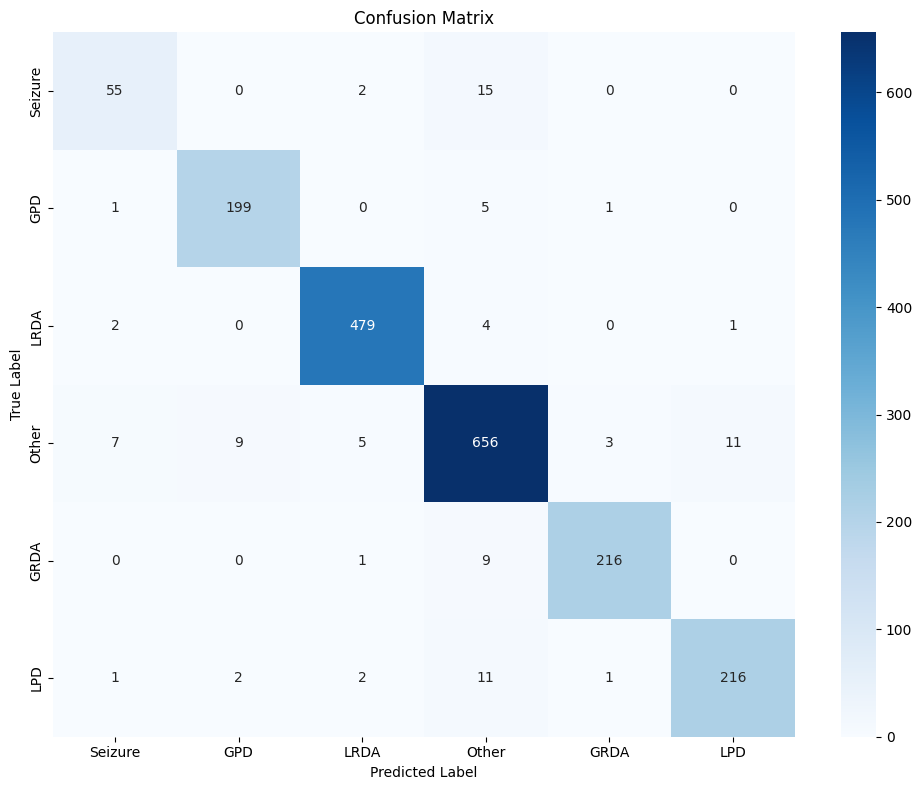

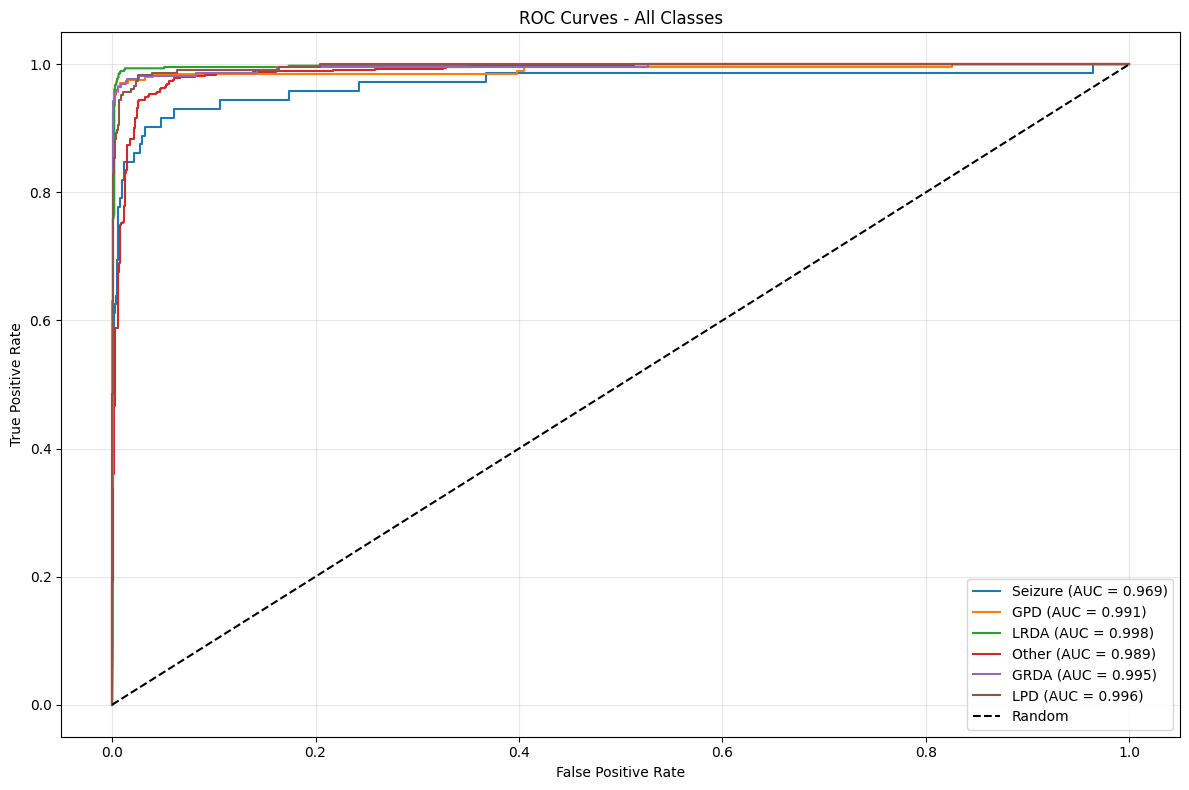

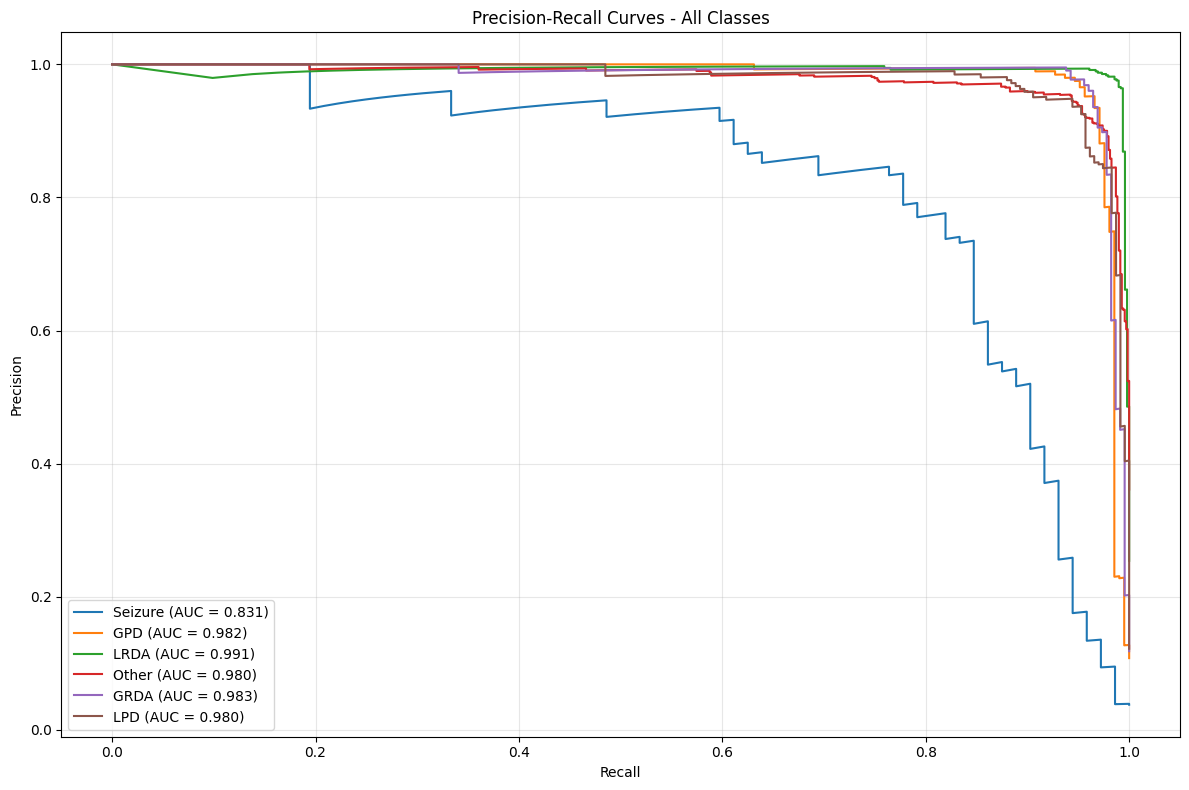

Creating t-SNE visualization...


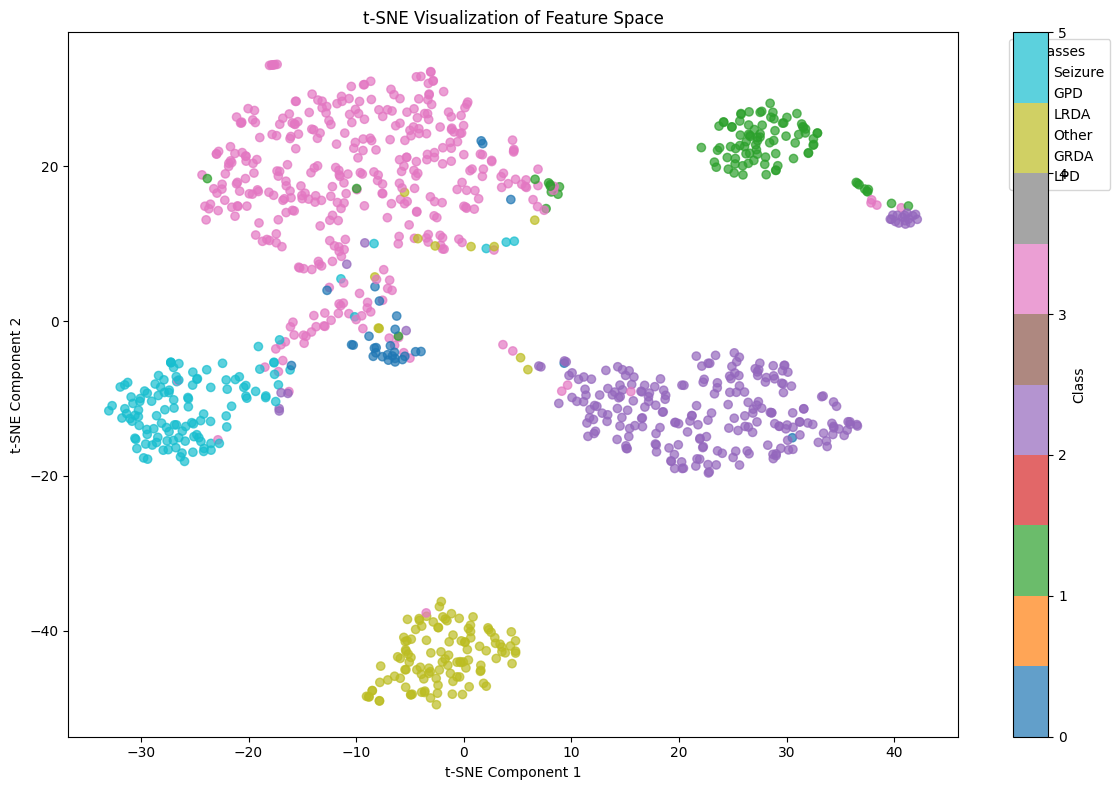

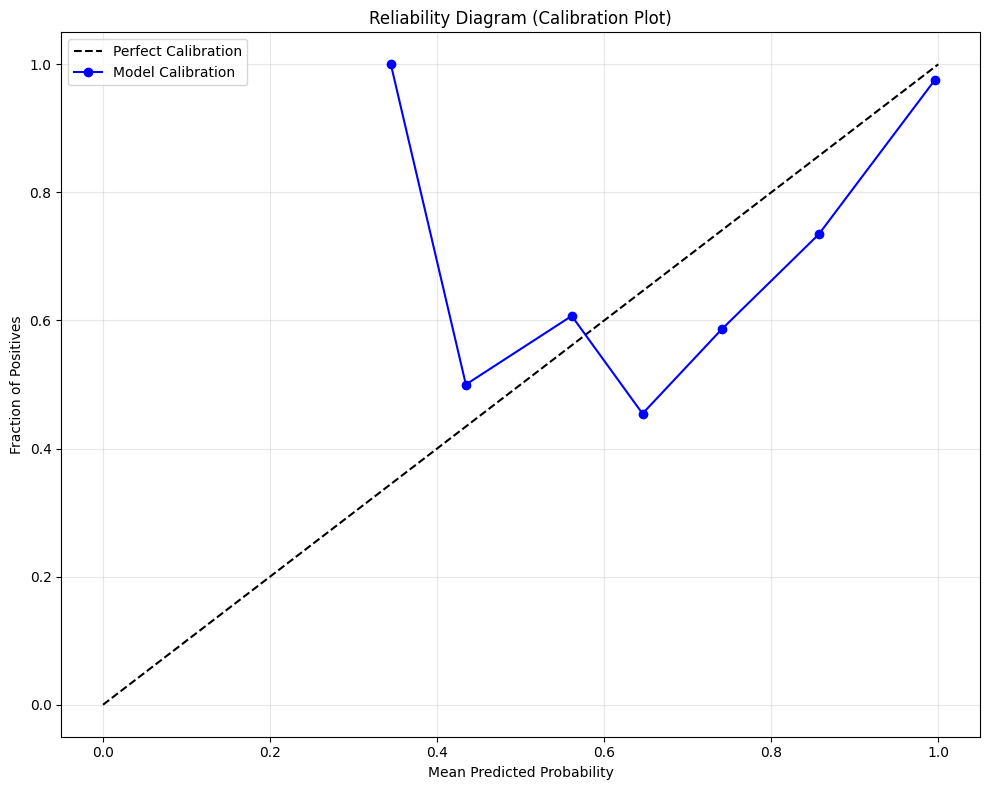

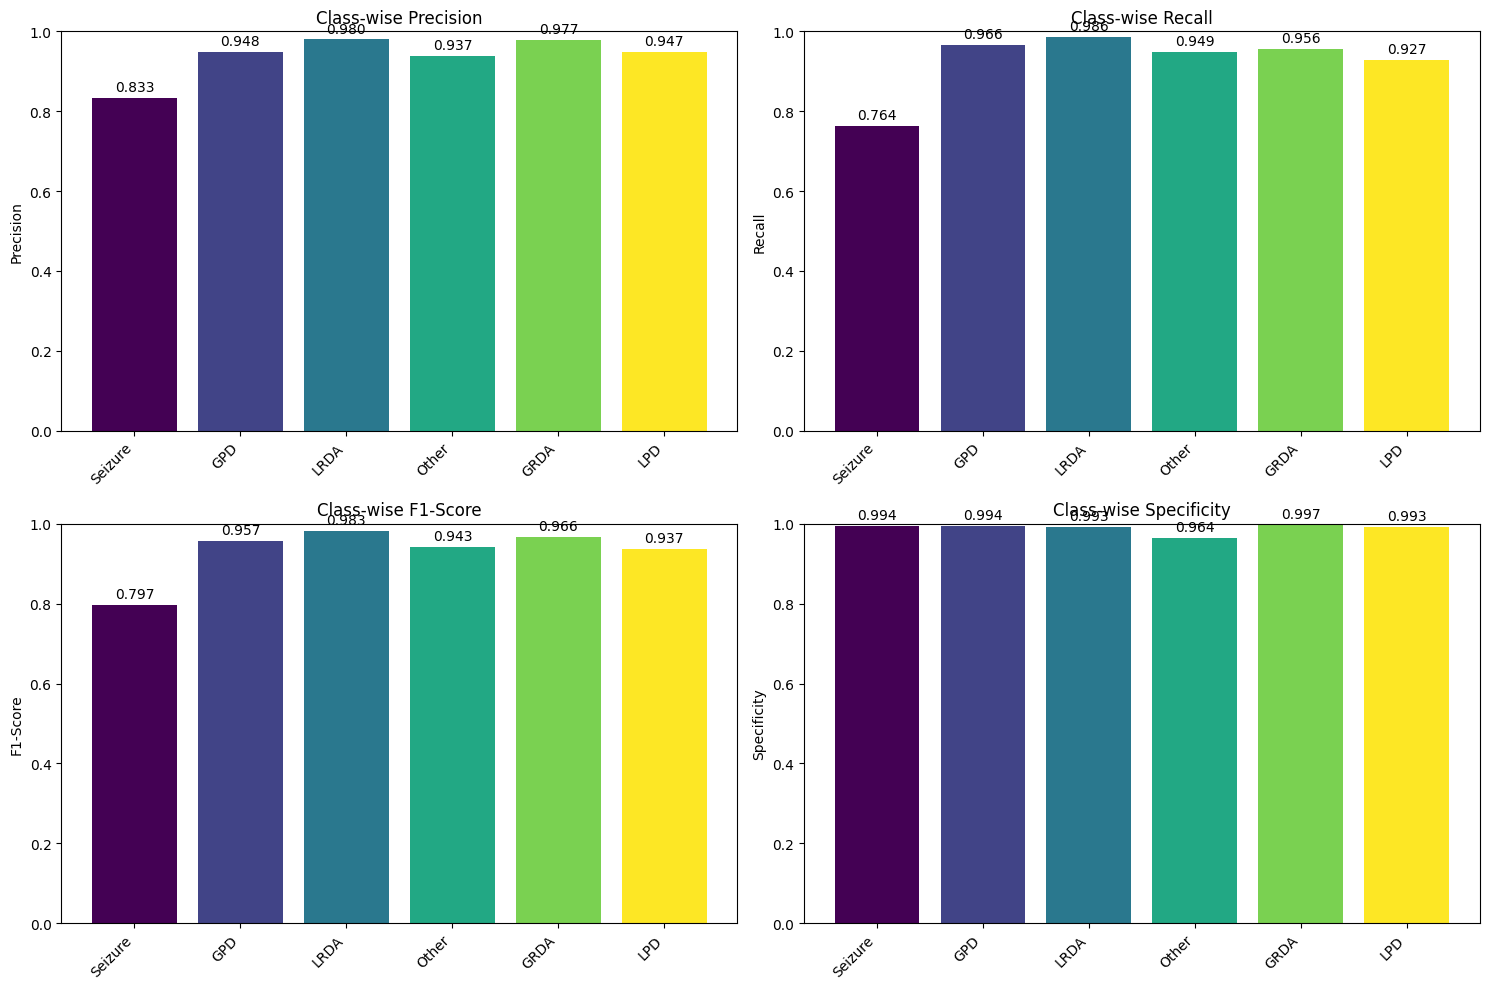

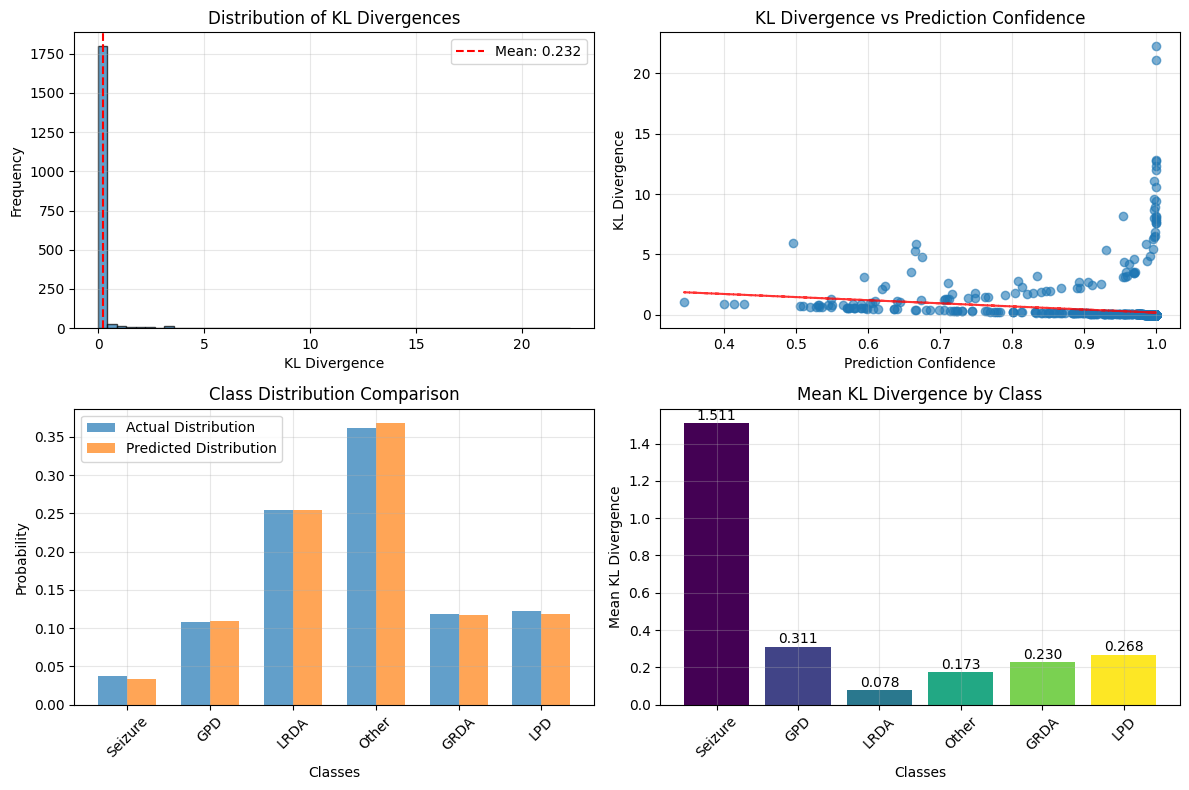

Results saved to efficientnet_hms_comprehensive_results.csv

Plotting training history...
Log file HMS_EfficientNetV2_S_Spect_Model_Training_log_v1.csv not found. Cannot plot training history.

Testing noise robustness...
Noise level 0.01: 95.19% accuracy
Noise level 0.05: 94.83% accuracy
Noise level 0.1: 93.99% accuracy
Noise level 0.2: 82.39% accuracy

Generating comprehensive report...
Comprehensive report saved to: HMS_EfficientNet_Evaluation_Report.md

EVALUATION COMPLETE
All metrics calculated, visualizations created, and report generated!

Files created:
- efficientnet_hms_comprehensive_results.csv
- HMS_EfficientNet_Evaluation_Report.md
- Multiple visualization PNG files
- training_validation_history.png


In [7]:
# Add this to your existing HMS_Efficientnet_Spect.ipynb after the training completes

# =====================================================================
# COMPREHENSIVE MODEL EVALUATION
# =====================================================================

# After your existing training code, add this evaluation section:

from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

print("\n" + "="*80)
print("STARTING COMPREHENSIVE MODEL EVALUATION")
print("="*80)

# Initialize the comprehensive evaluator
evaluator = ComprehensiveModelEvaluator(
    model=model, 
    test_loader=test_loader, 
    val_loader=val_loader,
    device=device,
    num_classes=6,
    class_names=['Seizure', 'GPD', 'LRDA', 'Other', 'GRDA', 'LPD']
)

# Run comprehensive evaluation
print("Running comprehensive evaluation...")
results = evaluator.evaluate_model(checkpoint_path="EfficientNetV2_S_Spect_Model_v1.pth")

# Print all results in formatted manner
evaluator.print_results()

# Create all visualizations
print("\nCreating visualizations...")
evaluator.create_visualizations(save_prefix="efficientnet_hms_evaluation")

# Save results to CSV for further analysis
evaluator.save_results_to_csv("efficientnet_hms_comprehensive_results.csv")

# Plot training history (accuracy and loss curves)
print("\nPlotting training history...")
plot_training_history("HMS_EfficientNetV2_S_Spect_Model_Training_log_v1.csv")

# =====================================================================
# ADDITIONAL ROBUSTNESS TESTING (OPTIONAL)
# =====================================================================

def test_noise_robustness(model, test_loader, device, noise_levels=[0.01, 0.05, 0.1, 0.2]):
    """Test model robustness to Gaussian noise"""
    print("\nTesting noise robustness...")
    model.eval()
    
    results = {}
    
    for noise_level in noise_levels:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                
                # Add Gaussian noise
                noise = torch.randn_like(X) * noise_level
                X_noisy = torch.clamp(X + noise, 0, 1)
                
                outputs = model(X_noisy)
                _, predicted = outputs.max(1)
                total += y.size(0)
                correct += predicted.eq(torch.argmax(y, dim=1)).sum().item()
        
        accuracy = 100. * correct / total
        results[f'noise_{noise_level}'] = accuracy
        print(f"Noise level {noise_level}: {accuracy:.2f}% accuracy")
    
    return results

# Test robustness to noise
noise_results = test_noise_robustness(model, test_loader, device)

# =====================================================================
# GENERATE COMPREHENSIVE REPORT
# =====================================================================

def generate_comprehensive_report(evaluator, noise_results=None):
    """Generate a comprehensive markdown report"""
    
    report = f"""
# HMS EfficientNet Model Evaluation Report

**Generated on:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Model Architecture
- **Model:** EfficientNet V2 Small
- **Number of Classes:** 6
- **Classes:** {', '.join(evaluator.class_names)}
- **Parameters:** {evaluator.results['total_params_m']:.2f}M
- **Model Size:** {evaluator.results['model_size_mb']:.2f} MB

## Overall Performance Metrics

### Primary Metrics
| Metric | Value |
|--------|-------|
| **Accuracy** | {evaluator.results['accuracy']:.4f} |
| **Precision (Macro)** | {evaluator.results['precision_macro']:.4f} |
| **Recall (Macro)** | {evaluator.results['recall_macro']:.4f} |
| **F1 Score (Macro)** | {evaluator.results['f1_macro']:.4f} |
| **AUC-ROC (Macro)** | {evaluator.results['auc_roc_macro']:.4f} |
| **Cohen's Kappa** | {evaluator.results['cohen_kappa']:.4f} |

### Additional Metrics
| Metric | Value |
|--------|-------|
| **Balanced Accuracy** | {evaluator.results['balanced_accuracy']:.4f} |
| **Matthews Correlation** | {evaluator.results['matthews_corr']:.4f} |
| **Log Loss** | {evaluator.results['log_loss']:.4f} |
| **Brier Score** | {evaluator.results['brier_score']:.4f} |
| **Expected Calibration Error** | {evaluator.results['ece']:.4f} |
| **AUC-PRC (Macro)** | {evaluator.results['auc_pr_macro']:.4f} |

## Class-wise Performance

| Class | Precision | Recall | F1-Score | Specificity | AUC-ROC | AUC-PRC |
|-------|-----------|--------|----------|-------------|---------|---------|"""
    
    for i, class_name in enumerate(evaluator.class_names):
        report += f"""
| {class_name} | {evaluator.results['precision_class'][i]:.4f} | {evaluator.results['recall_class'][i]:.4f} | {evaluator.results['f1_class'][i]:.4f} | {evaluator.results['specificity_class'][i]:.4f} | {evaluator.results['class_auc_roc'][i]:.4f} | {evaluator.results['class_auc_pr'][i]:.4f} |"""
    
    report += f"""

## Performance Characteristics

### Computational Efficiency
| Metric | Value |
|--------|-------|
| **Avg Inference Time** | {evaluator.results['avg_inference_time_ms']:.2f} ms/sample |
| **Throughput** | {evaluator.results['throughput_samples_per_sec']:.2f} samples/sec |
| **Total Test Samples** | {evaluator.results['total_test_samples']} |

### Model Calibration
| Metric | Value |
|--------|-------|
| **Calibration Slope** | {evaluator.results['calibration_slope']:.4f} |
| **Calibration Intercept** | {evaluator.results['calibration_intercept']:.4f} |

## Top-k Accuracy"""
    
    if 'top_3_accuracy' in evaluator.results:
        report += f"""
| Metric | Value |
|--------|-------|"""
        for key in evaluator.results:
            if key.startswith('top_') and key.endswith('_accuracy'):
                k = key.split('_')[1]
                report += f"""
| **Top-{k} Accuracy** | {evaluator.results[key]:.4f} |"""
    
    if noise_results:
        report += f"""

## Robustness Analysis

### Noise Robustness
| Noise Level | Accuracy |
|-------------|----------|"""
        for noise_level, accuracy in noise_results.items():
            level = noise_level.split('_')[1]
            report += f"""
| {level} | {accuracy:.2f}% |"""
    
    report += f"""

## Evaluation Summary
- **Evaluation Start:** {evaluator.results['evaluation_start_time']}
- **Evaluation End:** {evaluator.results['evaluation_end_time']}
- **Evaluation Time:** {evaluator.results['evaluation_time_hours']:.4f} hours

## Files Generated
- `efficientnet_hms_evaluation_confusion_matrix.png` - Confusion Matrix
- `efficientnet_hms_evaluation_roc_curves.png` - ROC Curves for All Classes
- `efficientnet_hms_evaluation_pr_curves.png` - Precision-Recall Curves
- `efficientnet_hms_evaluation_tsne.png` - t-SNE Visualization
- `efficientnet_hms_evaluation_calibration.png` - Reliability Diagram
- `efficientnet_hms_evaluation_classwise_metrics.png` - Class-wise Performance
- `training_validation_history.png` - Training History
- `efficientnet_hms_comprehensive_results.csv` - Detailed Results

## Model Recommendations

Based on the evaluation results:

1. **Overall Performance:** {'Excellent' if evaluator.results['accuracy'] > 0.9 else 'Good' if evaluator.results['accuracy'] > 0.8 else 'Moderate'} accuracy of {evaluator.results['accuracy']:.2%}
2. **Class Balance:** {'Well-balanced' if min(evaluator.results['recall_class']) > 0.7 else 'Some class imbalance detected'}
3. **Calibration:** {'Well-calibrated' if evaluator.results['ece'] < 0.1 else 'May need calibration improvement'}
4. **Efficiency:** {'Highly efficient' if evaluator.results['avg_inference_time_ms'] < 50 else 'Moderately efficient'}

"""
    
    # Save report to file
    with open("HMS_EfficientNet_Evaluation_Report.md", "w") as f:
        f.write(report)
    
    print("Comprehensive report saved to: HMS_EfficientNet_Evaluation_Report.md")
    return report

# Generate the comprehensive report
print("\nGenerating comprehensive report...")
report = generate_comprehensive_report(evaluator, noise_results)

print("\n" + "="*80)
print("EVALUATION COMPLETE")
print("="*80)
print("All metrics calculated, visualizations created, and report generated!")
print("\nFiles created:")
print("- efficientnet_hms_comprehensive_results.csv")
print("- HMS_EfficientNet_Evaluation_Report.md")
print("- Multiple visualization PNG files")
print("- training_validation_history.png")